# Sampling data (Dynamic, should be multiple points of data)
1. **Time (tctd)**: Typically, time might be measured in seconds (s), minutes (min), or hours (h). However, since it's common to have glider data in UTC or a similar time format, you could also represent it in Julian days or a specific timestamp format.

2. **Pressure (P)**: Pressure is commonly measured in decibars (dbar). In oceanography, the pressure sensor on a glider measures the depth pressure, and 1 dbar roughly corresponds to 1 meter of water depth.

3. **Pitch (pitch)**: Pitch angle is usually measured in degrees (°). It represents the inclination of the glider's nose relative to the horizontal plane.

4. **Buoyancy Drive (buoyancy_drive)**: This typically refers to the volume change in the glider's buoyancy engine, measured in cubic centimeters (cc) or milliliters (mL). It represents the change in buoyancy force due to changes in the glider's volume.

5. **Density (density)**: Water density is commonly measured in kilograms per cubic meter (kg/m³).

6. **U_adcp** (<span style="color:red">no need</span>): This likely refers to the velocity component measured by an Acoustic Doppler Current Profiler (ADCP). It's usually measured in meters per second (m/s).

# Fixed parameter (Static)
1. **mg**: mass of the glider (kg)

2. **Vg**: volume of the glider (m³)

3. **Cd0**: parasite drag coefficient

4. **epsilon**: compressibility of the hull (1/Pa)

5. **ah**: lift angle coefficient due to the hull (1/rad)

6. **Cd1**: induced drag coefficient (1/rad²)

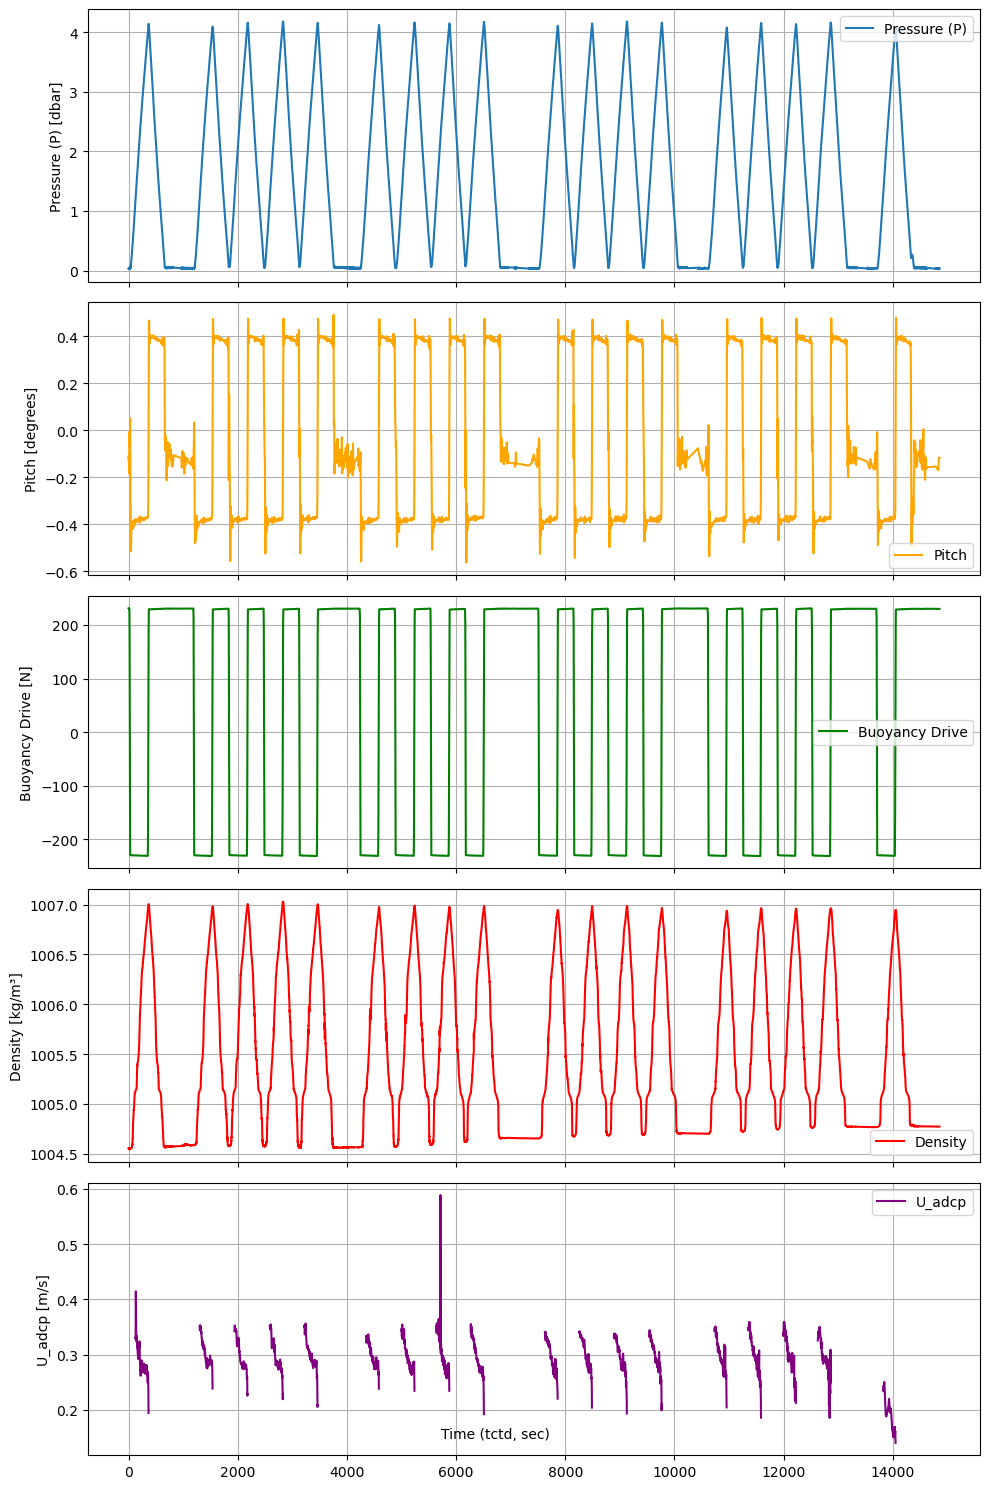

In [15]:
import numpy as np
import sys
sys.path.insert(0, '..')
import gliderflight
import matplotlib.pyplot as plt

# load some measurements. Data extracted from a glider mission and processed DVL data.
tctd, P, pitch, buoyancy_drive, density, U_adcp = np.load("./data/gliderflight_data.npy")

# Adjust tctd to start from time 0
tctd_adjusted = tctd - tctd[0]

# Create a figure and subplots with the adjusted tctd
fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

# Plot Pressure (P)
axs[0].plot(tctd_adjusted, P, label='Pressure (P)')
axs[0].set_ylabel('Pressure (P) [dbar]')
axs[0].legend(loc='best')
axs[0].grid(True)

# Plot Pitch
axs[1].plot(tctd_adjusted, pitch, label='Pitch', color='orange')
axs[1].set_ylabel('Pitch [degrees]')
axs[1].legend(loc='best')
axs[1].grid(True)

# Plot Buoyancy Drive
axs[2].plot(tctd_adjusted, buoyancy_drive, label='Buoyancy Drive', color='green')
axs[2].set_ylabel('Buoyancy Drive [N]')
axs[2].legend(loc='best')
axs[2].grid(True)

# Plot Density
axs[3].plot(tctd_adjusted, density, label='Density', color='red')
axs[3].set_ylabel('Density [kg/m³]')
axs[3].legend(loc='best')
axs[3].grid(True)

# Plot U_adcp
axs[4].plot(tctd_adjusted, U_adcp, label='U_adcp', color='purple')
axs[4].set_ylabel('U_adcp [m/s]')
axs[4].legend(loc='best')
axs[4].grid(True)

# Set shared x-axis label
fig.text(0.5, 0.04, 'Time (tctd, sec)', ha='center', va='center')

# Show the plot
plt.tight_layout()
plt.show()


In [3]:
# Setup a steady-state model to calibrate
GM = gliderflight.SteadyStateCalibrate(rho0=1004)  # rho0 might be the initial density.
GM.define(ah=3.8, Cd1=10.5)    # ah: lift angle coefficient due to the hull (1/rad);  Cd1 is induced drag coefficient (1/rad²)
GM.set_input_data(time=tctd, pressure=P, pitch=pitch, buoyancy_change=buoyancy_drive, density=density)
GM.OR(P*10<10)
GM.OR(P*10>35)
GM.define(Cd0=0.15, mg=70, Vg=70/1004)   # Cd0 is the parasite drag coefficient; mg: mass of the glider (kg); Vg: volume of the glider (m³)
calibration_result = GM.calibrate("Cd0", "mg", verbose=True)

Error: 2.6506776e-03  -  Cd0=0.15  mg=70
Error: 2.6394720e-03  -  Cd0=0.1575  mg=70
Error: 9.8799588e-02  -  Cd0=0.15  mg=73.5
Error: 9.3348932e-02  -  Cd0=0.1575  mg=66.5
Error: 4.5874525e-02  -  Cd0=0.1556  mg=68.25
Error: 4.5318331e-02  -  Cd0=0.1519  mg=71.75
Error: 2.3060860e-02  -  Cd0=0.1528  mg=70.88
Error: 2.5114360e-02  -  Cd0=0.1547  mg=69.12
Error: 1.4624721e-02  -  Cd0=0.1533  mg=70.44
Error: 1.6548451e-02  -  Cd0=0.1542  mg=69.56
Error: 2.8434227e-03  -  Cd0=0.1535  mg=70.22
Error: 1.3180703e-02  -  Cd0=0.154  mg=69.78
Error: 1.5455621e-03  -  Cd0=0.1536  mg=70.11
Error: 1.5602015e-03  -  Cd0=0.1611  mg=70.11
Error: 2.8349441e-03  -  Cd0=0.1573  mg=70.22
Error: 1.7670536e-03  -  Cd0=0.1574  mg=70.05
Error: 1.8886427e-03  -  Cd0=0.1573  mg=70.16
Error: 1.5878275e-03  -  Cd0=0.1574  mg=70.08
Error: 1.6508957e-03  -  Cd0=0.1574  mg=70.14
Error: 1.5523350e-03  -  Cd0=0.1574  mg=70.1
Error: 1.5441647e-03  -  Cd0=0.1499  mg=70.1
Error: 1.5620496e-03  -  Cd0=0.1443  mg=70.09
Err

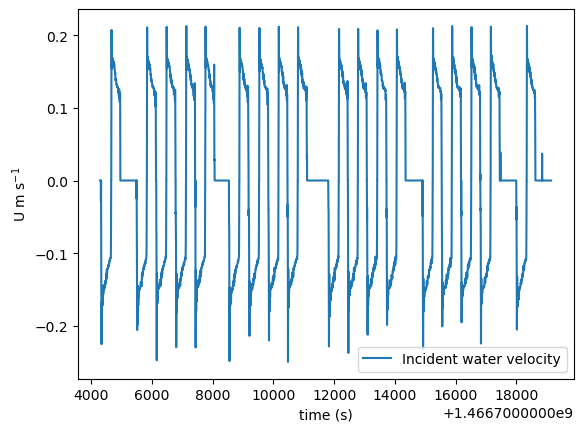

In [4]:
f, ax = plt.subplots(1,1)

ax.plot(GM.t, GM.wg, label='Incident water velocity')
ax.set_xlabel('time (s)')
ax.set_ylabel('U m s$^{-1}$')
ax.legend()

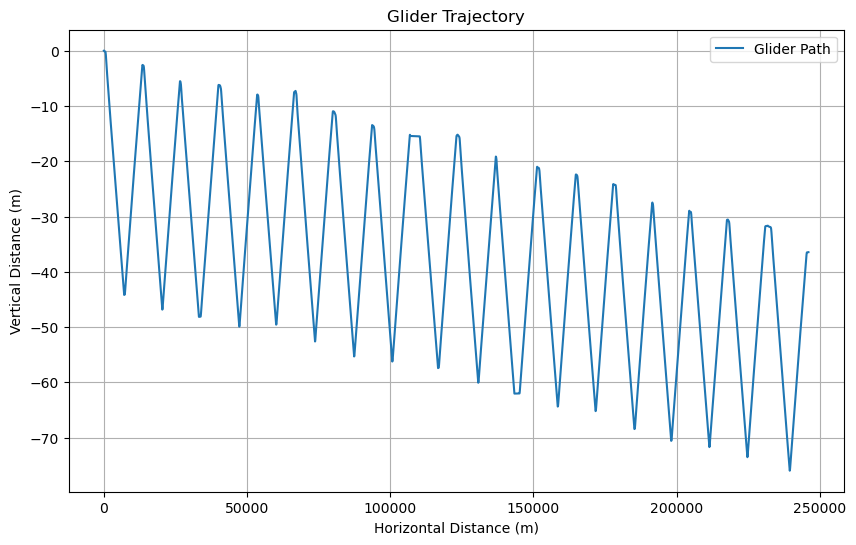

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure that pitch is in radians; if it's in degrees, convert it
pitch_rad = np.deg2rad(pitch)  # If pitch is in degrees

# Assuming time intervals are uniform
dt = np.diff(GM.t, prepend=GM.t[0])

# Calculate vertical and horizontal velocity components
wg = GM.wg
ug = wg / np.tan(pitch_rad)

# Calculate displacement in horizontal and vertical directions
dx = ug * dt
dz = wg * dt

# Accumulate displacement to compute position
x = np.cumsum(dx)
z = np.cumsum(dz)

# Plot the trajectory
plt.figure(figsize=(10, 6))
plt.plot(x, z, label='Glider Path')
plt.xlabel('Horizontal Distance (m)')
plt.ylabel('Vertical Distance (m)')
plt.title('Glider Trajectory')
plt.legend()
plt.grid(True)
plt.show()
